## One-Shot Image Verification using deep learning

Since the Olivetti face database is not large enough to do well training the network and the architecture of this network is really optimized for character recognition, it probably makes more sense to use a pretrained face recognition network for encoding the images. The result of this encoding will then be compared between the two and the final stage will be trained to complete the discrimination. Weights for the final layer can be loaded into the complete model after training that layer alone.

The best choice for pretrained face recognition networks is probably the VGG-Face network, as described in this paper - http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf, which has already been converted to Keras here - https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9.

One difficulty may be the differning format between the VGG face dataset and the Olivetti set. To accomodate the different format and grayscale the Olivetti images will be adjusted to match the expected input with a similar placement of the face in the image and the grayscale repeated on all three rbg planes.

The VGG-Faces based siamese model will be fine tuned to the first 30 of the Olivetti faces and the remaining 10 will be used to test one-shot accuracy.

As I was trying to determine the way faces should be framed in the image I found this paper which describes adapting the VGG-Faces model for cross-over learning - http://cs231n.stanford.edu/reports/2016/pdfs/006_Report.pdf

It seems that the Olivetti faces are probably reasonably well cropped, so we will only need to change them to RGB format for the input.

One thing I did not understand at the outset was that the model does not actually learn anything from the one image. All features need to be encoded in the network to begin with. So it is critically important that a wide range of faces be present in the training data. For this reason the VGG-Face dataset is probably not sufficient for the wider population as it was mostly trained on celebrity faces.

I was looking for how to merge the results from the branches and found this blog post on how someone implemented the model in the paper - https://sorenbouma.github.io/blog/oneshot/ So, some of the following code is adapted from that.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from sklearn.datasets import fetch_olivetti_faces
from itertools import combinations
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.initializers import TruncatedNormal
from keras.utils.data_utils import get_file
from PIL import Image
from sklearn.metrics import roc_curve

Populating the interactive namespace from numpy and matplotlib


### If we use 75% of the Olivetti Faces data set for training, the number of positive and negative pairs we can get is 9X5X30 = 1350 and 150x290 = 43,500.
We will draw evenly and randomly from those sets for training batches and run until we are not seeing much additional improvement.
For validation we will have 450 positive cases and 4500 negative cases. The validation data will be used to assess the training of the final layers and to construct the one-shot tests.

Seems that for training the final layer it may be faster to precompute the output of the VGG-Face branches for all the images and train the final layer on its own. I will see if I can figure out how to do that once I have things set up.

If the performance is not so good with only the final fully connected layer trained we could also make the second to last layer trainable and include it in the discriminator, with initial wieghts starting where they were for VGG-Face.

To multiply the amount of data we have we might also just do some transformations on the image vectors for training the final layer rather than on the original images. Perhaps a dropout of 10% of the components. If we were to start from the original images we could add noise or perform affine distortions that approximate changes in the angle of the photo or lighting without creating abnormal facial shapes.

### Improved source for VGG-Face
After mucking around with VGG-Face trying to get it to work I think I found a better source for a Keras-based VGG-Face model ready for fine tuning here - https://github.com/rcmalli/keras-vggface. It has the weights in TensorFlow format.

### AWS
Although it was not really necessary due to the small amount of data and single training layer, training was performed on an AWS p2 instance. If we had progressed to training more of the fully connected layers it may have been a help to have the GPU machine.

In [47]:
WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_v2.h5'

class Siamese_Face_Tester(object):
    """Loads Olivetti Face data and generates sets for training and testing one-shot learning on Siamese Network."""
    def __init__(self):
        self.train, self.test = self.new_train_test_split()
        # Pairs of indices for images of the same subject.
        self.test_pairs_pos, self.train_pairs_pos = self.get_pos_pairs()
        # Train and test sets for training the discriminator.
        self.train_pairs = []
        self.train_target = []
        self.test_pairs = []
        self.test_target = []
        self.refresh_train_sets()
        # Fetch and convert Olivetti Face data.
        self.data = fetch_olivetti_faces()
        self.images = np.zeros((400, 224, 224, 3))
        for i in range(400):
            self.images[i, :, :, :] = self.convert_image(self.data.images[i])
        self.image_vectors = None
        self.branch_encoder = None
        self.weights_path = None
        self.discriminator = self.get_discriminator()


    def convert_image(self, img):
        """Convert gray scale image to color in [h, w, channels] format."""
        new_image = Image.fromarray(img).resize((224, 224))
        img = np.asarray(new_image)
        color_image = np.array([img, img, img])
        return transpose(color_image, (1, 2, 0))


    def new_train_test_split(self):
        """Olivetti Faces includes 40 sets of 10 images. This returns a 75/25 random split of 40 indices."""
        # Randomly choose 75% of the indices for the Olivetti subjects for the training set.
        train = np.random.choice(range(40), 30, replace=False)
        # Take the remaining 25% for the test set.
        test = np.array([idx for idx in range(40) if idx not in train])
        return train, test


    def get_pos_pairs(self):
        """Returns all possible positive pairs for the current train-test split."""
        test_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in self.test])
        train_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in self.train])
        return test_pairs_pos, train_pairs_pos


    def refresh_train_sets(self, batch_size=32):
        """Refreshes the train and test sets of index pairs and targets with a new random draw of negative pairs."""
        # Make the train set an integer multiple of the batch size (not sure if this matters...)
        drop = len(self.train_pairs_pos)%batch_size
        train_pairs = np.concatenate((self.train_pairs_pos[:-drop], self.draw_random_neg_pairs(self.train, len(self.train_pairs_pos)-drop)))
        train_targets = np.concatenate((np.ones(len(train_pairs)/2), np.zeros(len(train_pairs)/2)))
        train_labeled = np.hstack([train_pairs, np.array([train_targets]).T])
        np.random.shuffle(train_labeled)
        self.train_pairs = train_labeled[:, :2]
        self.train_target = train_labeled[:, 2]
        # Repeat same procedure for the test set. Clearly could be refactored in some way, but no time now.
        drop = len(self.test_pairs_pos)%batch_size
        test_pairs = np.concatenate((self.test_pairs_pos[:-drop], self.draw_random_neg_pairs(self.test, len(self.test_pairs_pos)-drop)))
        test_targets = np.concatenate((np.ones(len(test_pairs)/2), np.zeros(len(test_pairs)/2)))
        test_labeled = np.hstack([test_pairs, np.array([test_targets]).T])
        np.random.shuffle(test_labeled)
        self.test_pairs = test_labeled[:, :2]
        self.test_target = test_labeled[:, 2]
        

    def random_neg_pair(self, subject_indices):
        """Takes an array of subject indices and returns a pair of indices to non-matching image vectors."""
        subject = random.choice(subject_indices)
        ind1 = 10*subject + random.choice(range(10))
        others = subject_indices.tolist()
        others.remove(subject)
        ind2 = 10*random.choice(others) + random.choice(range(10))
        return [ind1, ind2]


    def draw_random_neg_pairs(self, subject_indices, number):
        """Returns a set of number unique negative pairs"""
        pairs = []
        while (len(pairs) < number):
            pair = set(self.random_neg_pair(subject_indices))
            if pair not in pairs:
                pairs.append(pair)
        return np.array([list(s) for s in pairs])


    def vgg_face(self, weights_path=None):
        """The VGGFace network."""
        img = Input(shape=(224, 224, 3))

        conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False)(img)
        conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', trainable=False)(conv1_1)
        pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)(conv1_2)

        conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', trainable=False)(pool1)
        conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', trainable=False)(conv2_1)
        pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2', trainable=False)(conv2_2)

        conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', trainable=False)(pool2)
        conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', trainable=False)(conv3_1)
        conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', trainable=False)(conv3_2)
        pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3', trainable=False)(conv3_3)

        conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', trainable=False)(pool3)
        conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', trainable=False)(conv4_1)
        conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', trainable=False)(conv4_2)
        pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4', trainable=False)(conv4_3)

        conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', trainable=False)(pool4)
        conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', trainable=False)(conv5_1)
        conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', trainable=False)(conv5_2)
        pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='pool5', trainable=False)(conv5_3)

        flat = Flatten()(pool5)
        fc6 = Dense(4096, activation='relu', name='fc6', trainable=False)(flat)
        fc7 = Dense(4096, activation='relu', name='fc7', trainable=False)(fc6)
        out = Dense(2622, activation='softmax', name='fc8')(fc7)

        model = Model(inputs=img, outputs=out)

        if weights_path:
            model.load_weights(weights_path)

        return model


    def get_branch_model(self):
        """Returns a model that can be used to encode images into vectors using the trained VGG-Face model."""
        if self.branch_encoder == None:
            # Set up VGGFace network and load weights.
            if self.weights_path == None:
                self.get_VGG_weights()
            encode_image = self.vgg_face(self.weights_path)

            # Strip off the final layer used for prediction, leaving the image feature vector.
            # Unfortunately, popping off layers still does not work correctly. After popping
            # you still need to reassign the output of the model to the final layer or it will
            # still be trying to look at the old final layer. See here - https://github.com/fchollet/keras/issues/2371
            encode_image.layers.pop()
            encode_image.outputs = [encode_image.layers[-1].output]
            encode_image.layers[-1].outbound_nodes = []
            self.branch_encoder = encode_image
        return self.branch_encoder
    
    
    def encode_image_vectors(self):
        """Uses the image encoding branch to turn the Olivetti images into vectors."""
        encoder = self.get_branch_model()
        vectors = encoder.predict(self.images[:16], batch_size = 16)
        for i in range(24):
            vectors = np.concatenate((vectors, encoder.predict(self.images[16*(i+1):16*(i+2)], batch_size = 16)))
        return vectors


    def get_image_vectors(self):
        """Returns the image vectors, computing them if necessary."""
        if self.image_vectors == None:
            self.image_vectors = self.encode_image_vectors()
        return self.image_vectors
    
    
    def get_VGG_weights(self):
        """Download VGGFace weights if they are not present."""
        self.weights_path = get_file('rcmalli_vggface_tf_v2.h5',
                                     WEIGHTS_PATH,
                                     cache_subdir='models')
        
        
    def get_discriminator(self):
        """The discriminator is the part of the siamese network that we will train to tell the difference between encoded image vectors."""
        discrim_input = Input(shape=(2, 4096))
        # Merge two encoded inputs with the L1 distance between them.
        both = Lambda(lambda x: np.abs(x[:,0]-x[:,1]), output_shape=(4096,))(discrim_input)
        # Make the final prediction layer as described in the paper. This is the only layer we will train to begin with.
        # We can unfreeze additional fc layers and train them if it seems to be needed.
        prediction = Dense(1, activation='sigmoid', bias_initializer=TruncatedNormal(mean=0.5, stddev=0.01))(both)
        discriminator = Model(inputs=discrim_input, outputs=prediction)
        return discriminator
    
    
    def get_oneshot_set(self, N):
        """Return a set of N pairs, one of which has two images of the same face."""
        pairs = [10*np.random.choice(self.test) + np.random.choice(range(10), 2, replace=False)]
        pairs.extend(self.draw_random_neg_pairs(self.test, N-1))
        targets = np.zeros((N,))
        targets[0] = 1
        return [[np.array(self.image_vectors[int(pair[0])]),
                 np.array(self.image_vectors[int(pair[1])])] for pair in pairs], targets
    
    
    def test_oneshot(self, N, k, model=None, verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks.
        
        Thanks here to Soren Bouma for a helpful function! - https://sorenbouma.github.io/blog/oneshot/ 
        """
        if model == None:
            model = self.discriminator
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k, N))
        for i in range(k):
            inputs, targets = self.get_oneshot_set(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct, N))
        return percent_correct

In [48]:
tester = Siamese_Face_Tester()
vectors = tester.get_image_vectors()
tester.discriminator.compile(loss="binary_crossentropy", optimizer=Adam())
X_train = [[np.array(vectors[int(pair[0])]), np.array(vectors[int(pair[1])])] for pair in tester.train_pairs]
X_test = [[np.array(vectors[int(pair[0])]), np.array(vectors[int(pair[1])])] for pair in tester.test_pairs]

In [49]:
tester.discriminator.fit(x=X_train, y=tester.train_target, epochs=40, validation_data=(X_test, tester.test_target))

Train on 2688 samples, validate on 896 samples
Epoch 1/40
2688/2688 [==============================] - 0s - loss: 0.6340 - val_loss: 0.6043
Epoch 2/40
2688/2688 [==============================] - 0s - loss: 0.5681 - val_loss: 0.5848
Epoch 3/40
2688/2688 [==============================] - 0s - loss: 0.5451 - val_loss: 0.5754
Epoch 4/40
2688/2688 [==============================] - 0s - loss: 0.5250 - val_loss: 0.5687
Epoch 5/40
2688/2688 [==============================] - 0s - loss: 0.5061 - val_loss: 0.5621
Epoch 6/40
2688/2688 [==============================] - 0s - loss: 0.4882 - val_loss: 0.5591
Epoch 7/40
2688/2688 [==============================] - 0s - loss: 0.4712 - val_loss: 0.5547
Epoch 8/40
2688/2688 [==============================] - 0s - loss: 0.4550 - val_loss: 0.5513
Epoch 9/40
2688/2688 [==============================] - 0s - loss: 0.4397 - val_loss: 0.5490
Epoch 10/40
2688/2688 [==============================] - 0s - loss: 0.4249 - val_loss: 0.5471
Epoch 11/40
2688/2688 

In [50]:
y_pred = tester.discriminator.predict(X_test)

In [51]:
fpr, tpr, thresholds = roc_curve(tester.test_target, y_pred)

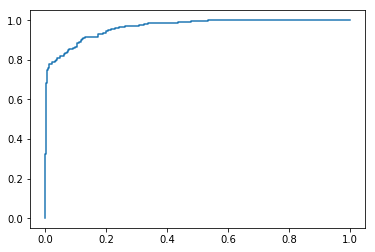

In [45]:
plt.plot(fpr, tpr)
plt.show()

## ROC Curve
Not too bad for only 40 Epochs of training on the final layer. This is an indication of performance for a 1 of 2 one-shot learning task. So not really very good, but let's go on to check the one-shot performance for larger sets.

In [66]:
tester.test_oneshot(5, 50)

82.0

In [57]:
# Plot percent correct versus number in one-shot task set. We take an average over 1000 trials
# of the one-shot task for set sizes from 2 - 21.
accuracy = []
for i in range(20):
    accuracy.append(tester.test_oneshot(i+2, 1000))
x = np.array(range(20)) + 2

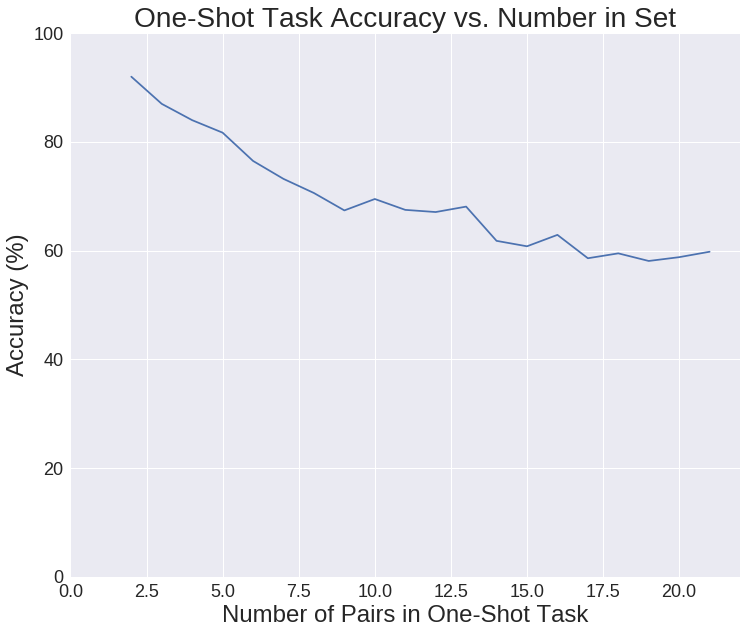

In [64]:
import seaborn as sns

plt.figure(figsize=(12,10))
plt.plot(x, accuracy)
plt.title('One-Shot Task Accuracy vs. Number in Set', fontsize = 28)
plt.xlabel('Number of Pairs in One-Shot Task', fontsize = 24)
plt.ylabel('Accuracy (%)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlim([0, 22])
plt.ylim([0, 100])
plt.show()

## So, accuracy drops off pretty quickly

# Summary Notes:
## What an awesome experience this was
* This is actually the first time I have really done a deep learning project on my own. It was at a perfect level for me to get into it. Previously I have only run things with a lot of hand holding.
* I loved the discovery of how easy it is to do transfer learning.
* I did not have time to go back and create the full model that would take two images to compare, but it would not be difficult to save the trained weights from the discriminator and load them into the combined model.
* Running the calculation of the image vectors actually took quite a while so it would have been a real waste of time to train on the complete network.

## Steps for improvement
* First step would probably be to come up with some ways to augment the training data. The Olivetti set is just so small.
    * Some of those might be to add noise to the images.
    * Add a constant offset for all values.
    * Small affine distortions that do not result in unnatural faces, but look more like side, top or bottom views.
    * Find more face data. Seems like many likely candidates here - http://www.face-rec.org/databases/
* Additional performance could be achieved by training the second to last fully connected layer from the VGGFace model.